In [120]:
import tensorflow as tf
import pandas as pd
import pickle
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import cv2


with open('models/label_encoder.pkl', 'rb') as file:
    label_encoder = pickle.load(file)
model = tf.keras.models.load_model('models/my_model.keras')

In [121]:
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 182, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 26, 28, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 26, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_56 (Activation)      │ (None, 26, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 7, 7, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_57 (Activation)      │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 49)             │        76,881 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 315,221 (1.20 MB)

 Trainable params: 105,009 (410.19 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 210,020 (820.39 KB)

In [152]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, pred = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(pred[0])
        print(pred_index)
        class_channel = pred[:pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    if grads is None:
        raise ValueError("Gradients are None. Check if the pred_index and class_channel are set correctly.")

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, top_3_classes, alpha=0.4):
    img = image.load_img(img_path)
    img = image.img_to_array(img)

    plt.figure(figsize=(24, 12))
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(img_path))
    plt.title('Original Image')
    plt.axis('off')
    

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * alpha + img
    superimposed_img = np.uint8(superimposed_img)

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(top_3_classes[0])
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
images/doge/57.jpg
['doge' 'singha' 'dooly']
12


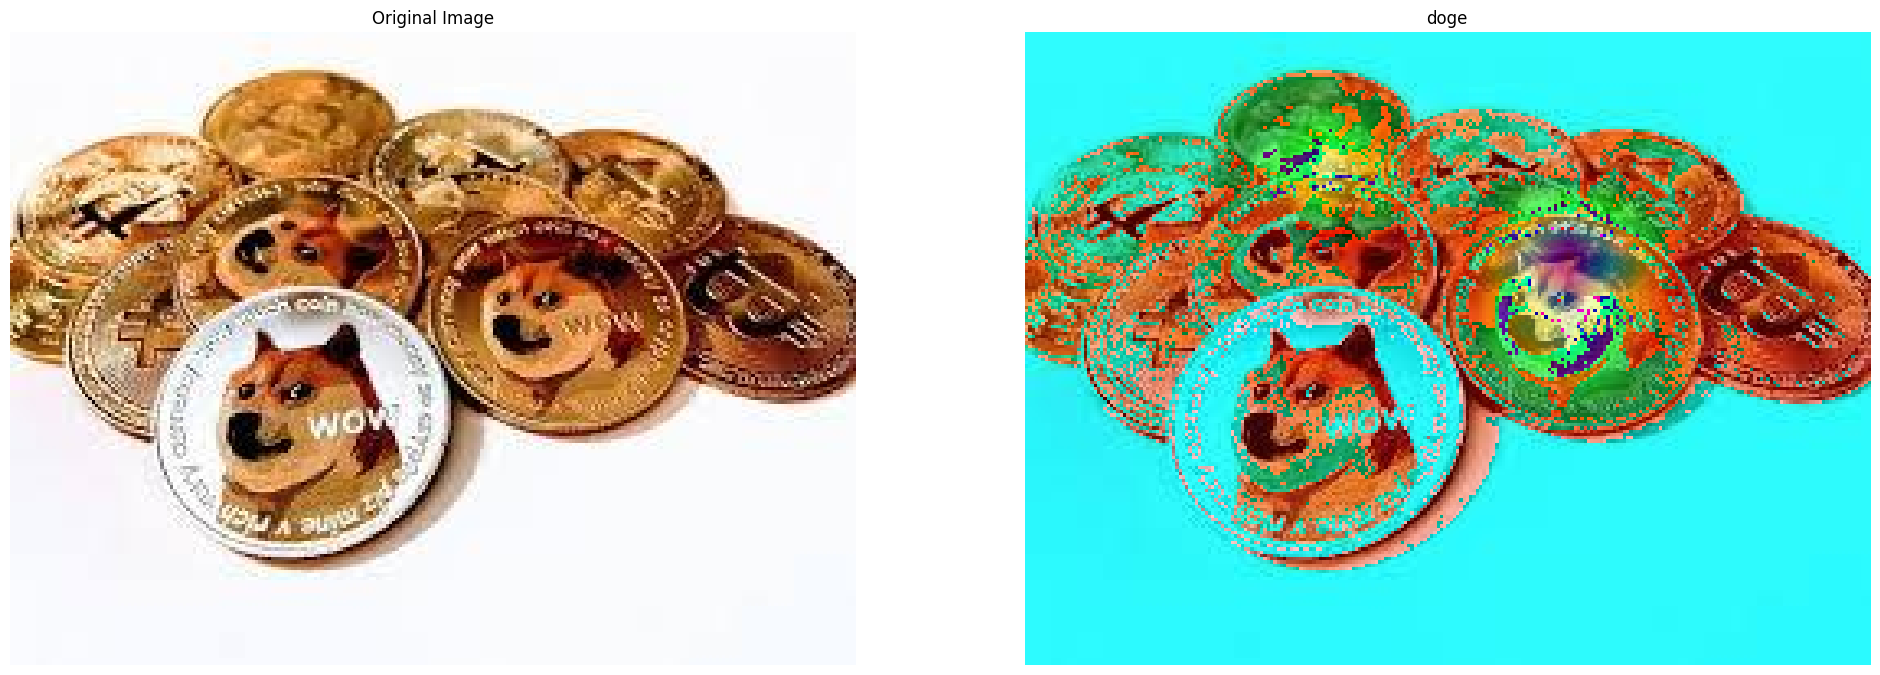

In [225]:
import random
train = pd.read_csv("data/raw_train.csv")

img_path = train.iloc[random.randint(0,9000)]["path"]
img = image.load_img(img_path, target_size=(182,192))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

pred = model.predict(img_array)

top_3_indices = np.argsort(pred[0])[-3:][::-1]
top_3_probs = pred[0][top_3_indices]
top_3_classes = label_encoder.inverse_transform(top_3_indices)

print(img_path)
print(top_3_classes)

heatmap = make_gradcam_heatmap(img_array, model, "conv2d_47", pred_index = np.argsort(pred[0])[0])
display_gradcam(img_path, heatmap, top_3_classes)

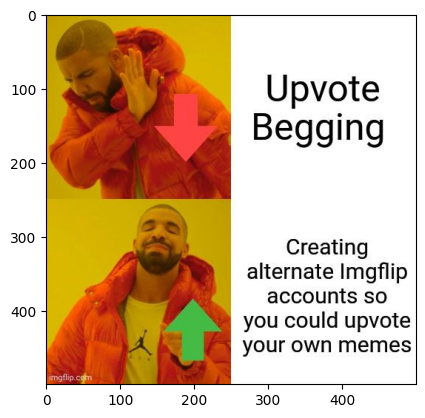

In [113]:
plt.imshow(Image.open(img_path))